Pobranie repozytorium i instalacja wymagan

In [1]:
!pip3 install -U openmim
!mim install mmcv-full
!mim install mmdet
!git clone https://github.com/open-mmlab/mmrotate.git
%cd mmrotate
!pip install -e .

Pobranie przetrenowanego modelu

In [2]:
!mim download mmrotate --config s2anet_r50_fpn_1x_dota_le135 --dest .

/usr/local/lib/python3.7/dist-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '
processing s2anet_r50_fpn_1x_dota_le135...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.4/148.4 MiB 22.8 MB/s eta 0:00:00
Successfully downloaded s2anet_r50_fpn_1x_dota_le135-5dfcf396.pth to /content/mmrotate
Successfully dumped s2anet_r50_fpn_1x_dota_le135.py to /content/mmrotate


Pobranie zbioru danych z dysku Google

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!apt install unzip
!unzip "/content/drive/MyDrive/mmRotate_data_PV.zip" -d "/content/mmrotate"

Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.2).


Przypisanie klass do zbioru danych

In [4]:
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset
@ROTATED_DATASETS.register_module()
class PVDataset(DOTADataset):
    CLASSES = ('PV_module', 'DI', 'HS', 'TR', 'MH', 'REF')

/usr/local/lib/python3.7/dist-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


Ustawienie zalecancyh nastaw dla architektury 

In [5]:
from mmcv import Config
cfg = Config.fromfile('./configs/s2anet/s2anet_r50_fpn_1x_dota_le135.py')

Modyfikacja ustawien

In [6]:
from mmdet.apis import set_random_seed
cfg.dataset_type = 'PVDataset'
cfg.data_root = 'mmRotate_data_PV/'
cfg.data.test.type = 'PVDataset'
cfg.data.test.data_root = 'mmRotate_data_PV/'
cfg.data.test.ann_file = 'test'
cfg.data.test.img_prefix = 'images'
cfg.data.train.type = 'PVDataset'
cfg.data.train.data_root = 'mmRotate_data_PV/'
cfg.data.train.ann_file = 'train'
cfg.data.train.img_prefix = 'images'
cfg.data.val.type = 'PVDataset'
cfg.data.val.data_root = 'mmRotate_data_PV/'
cfg.data.val.ann_file = 'valid'
cfg.data.val.img_prefix = 'images'
cfg.model.fam_head.num_classes = 6
cfg.model.odm_head.num_classes = 6
cfg.load_from = 's2anet_r50_fpn_1x_dota_le135-5dfcf396.pth'
cfg.work_dir = './tutorial_exps'
cfg.lr_config.warmup = None
cfg.runner.max_epochs = 100
cfg.log_config.interval = 10
cfg.evaluation.metric = 'mAP'
cfg.evaluation.interval = 3
cfg.checkpoint_config.interval = 3
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device='cuda'
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]
print(f'Config:\n{cfg.pretty_text}')

Dodatkowa modyfikacja optymalizatora

In [7]:
cfg.optimizer_config = dict(_delete_=True, grad_clip=dict(max_norm=35, norm_type=2))
cfg.optimizer = dict(type='Adam', lr=0.0003, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=dict(max_norm=35, norm_type=2))

Uczenie sieci

In [8]:
import os.path as osp
import mmcv
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
datasets = [build_dataset(cfg.data.train)]
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-11-17 15:37:25,293 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-11-17 15:37:25,458 - mmdet - INFO - load checkpoint from local path: s2anet_r50_fpn_1x_dota_le135-5dfcf396.pth
2022-11-17 15:37:25,585 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for fam_head.retina_cls.weight: copying a param with shape torch.Size([15, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([6, 256, 3, 3]).
size mismatch for fam_head.retina_cls.bias: copying a param with shape torch.Size([15]) from checkpoint, the shape in current model is torch.Size([6]).
size mismatch for odm_head.odm_cls.weight: copying a param with shape torch.Size([15, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([6, 256, 3, 3]).
size mismatch for odm_head.odm_cls.bias: copying a param with shape torch.Size([15]) from checkpoint, the shape in current model is torch.Size([6]).
2022-11-17 15:37:25,589 - mmdet - IN

Tensorboard

In [9]:
%load_ext tensorboard
%tensorboard --logdir ./tutorial_exps/tf_logs/

<IPython.core.display.Javascript object>

Prezentacja wyników detekcji

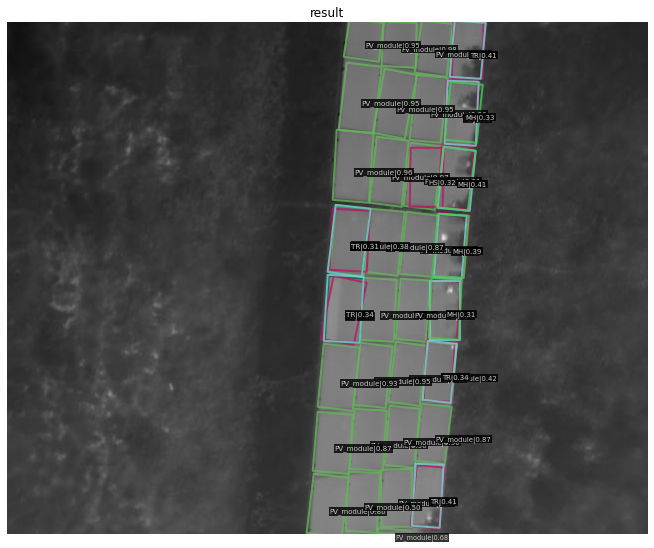

In [10]:
from mmdet.apis import inference_detector, show_result_pyplot
img = mmcv.imread('mmRotate_data_PV/images/DJI_1_MK (388).png')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)